In [3]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
from scipy.ndimage import gaussian_filter


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import column,row
output_notebook(hide_banner=True)
import cartopy.crs as ccrs
import cartopy

from scipy.stats import t,linregress,pearsonr

from precip_model_functions import *

# O'Gorman & Schneider precip model
$-\left\{\omega\left.\dfrac{dq_s}{dp}\right|_{\theta_e}\right\}$

In [2]:
ct = "nepal"
ds = rx5[ct]
lonlat = box[ct]["small"]

for d in ds :
    Get the five days around d
    dp = pd.to_datetime(d, format='%Y%m%d')
    d5 = [(dp + pd.Timedelta(days=i)).strftime("%Y%m%d") for i in range(-2,3)]  
    
    t=time.time()
    pr,omegas = precip_model_OGorman(d5,lonlat,[7])
    pr[0].to_netcdf(    "/global/cscratch1/sd/qnicolas/precipmodel/rx5/pr/pr.omegaupslopeblqe2sinXqinteg.plev8_1.%s.%s.nc"%(d,ct))
    omegas[0].to_netcdf("/global/cscratch1/sd/qnicolas/precipmodel/rx5/omega/e5.omegaupslopeblqe2sin.plev8_1.%s.%s.nc"%(d,ct))
    print("Done ",d,(time.time()-t)/60)
    

elapsed time / temperature, sfc pressure :  5.323951244354248
elapsed time / upslope omega :  9.688560962677002
elapsed time / ERA5 omega :  4.905125141143799
elapsed time / ub,vb and 2m temperature :  1.155160903930664
elapsed time / specific humidity :  4.487386226654053
elapsed time / geopotential height :  4.157498598098755
elapsed time / ub,vb and 2m temperature :  0.677882194519043
elapsed time / specific humidity :  3.982900619506836
elapsed time / geopotential height :  3.6832377910614014
Done  19980620 0.8359210213025411
elapsed time / temperature, sfc pressure :  4.648052215576172
elapsed time / upslope omega :  9.535075664520264
elapsed time / ERA5 omega :  4.646984100341797
elapsed time / ub,vb and 2m temperature :  1.118363857269287
elapsed time / specific humidity :  4.561939716339111
elapsed time / geopotential height :  4.097891569137573
elapsed time / ub,vb and 2m temperature :  0.6771755218505859
elapsed time / specific humidity :  4.014712572097778
elapsed time / geo

## Model with true omega vs model with upslope omega vs TRMM

In [15]:
def plot_precips(days,pr,ctname):
    assert len(pr)>=6
    flag=0
    pr_era5_og       = pr[0]
    pr_upsmean_og    = pr[1]
    pr_upssin_og     = pr[2]
    pr_upsblqesin_og = pr[3]
    pr_trmm          = pr[-2]
    pr_era5          = pr[-1]
    if len(pr)==7:
        flag=1
        pr_upsblqe2sin_og = pr[4]
        
    m=np.max(pr)
        
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,5))
    ax1.plot(days,np.array(pr_trmm),label="TRMM",color="green")
    ax1.plot(days,np.array(pr_era5),label="ERA5",color="magenta")
    ax1.plot(days,np.array(pr_era5_og)   ,label="O'Gorman w/ ERA5 omega")
    #ax1.plot(days,np.array(pr_upsmean_og)   ,label="O'Gorman w/ cst. upslope omega")
    ax1.plot(days,np.array(pr_upssin_og)   ,label="O'Gorman w/ sin upslope omega",color="k")
    ax1.plot(days,np.array(pr_upsblqesin_og)   ,label="O'Gorman w/ sin upslope+convective omega",color="gold")
    if flag:
        ax1.plot(days,np.array(pr_upsblqe2sin_og)   ,label="O'Gorman w/ sin upslope+convective omega (1% of clouds)",color="y")
    ax1.set_xlabel("date")
    ax1.set_ylabel("event precip (mm)")
    
    
    ax2.scatter(np.array(pr_era5),np.array(pr_era5_og)   ,        label="O'Gorman w/ ERA5 omega, r=%.2f, R^2=%.2f"%(np.corrcoef(pr_era5,pr_era5_og   )[0,1],rsquared(pr_era5,pr_era5_og   )))
    #ax2.scatter(np.array(pr_era5),np.array(pr_upsmean_og),label="O'Gorman w/ cst. upslope omega, r=%.2f, R^2=%.2f"%(np.corrcoef(pr_era5,pr_upsmean_og)[0,1],rsquared(pr_era5,pr_upsmean_og)))
    ax2.scatter(np.array(pr_era5),np.array(pr_upssin_og) , label="O'Gorman w/ sin upslope omega, r=%.2f, R^2=%.2f"%(np.corrcoef(pr_era5,pr_upssin_og )[0,1],rsquared(pr_era5,pr_upssin_og )),color="k")
    ax2.scatter(np.array(pr_era5),np.array(pr_upsblqesin_og),label="O'Gorman w/ sin upslope+convective omega, r=%.2f, R^2=%.2f"%(np.corrcoef(pr_era5,pr_upsblqesin_og)[0,1],rsquared(pr_era5,pr_upsblqesin_og)),color="gold")
    if flag:
        ax2.scatter(np.array(pr_era5),np.array(pr_upsblqe2sin_og),label="O'Gorman w/ sin upslope+convective omega (1%% of clouds), r=%.2f, R^2=%.2f"%(np.corrcoef(pr_era5,pr_upsblqe2sin_og)[0,1],rsquared(pr_era5,pr_upsblqe2sin_og)),color="y")
    ax2.plot(np.array(pr_era5),np.array(pr_era5),color="magenta",label="ERA5 (1 to 1 line)")
    ax2.set_xlabel("ERA5 event precip (mm)")
    ax2.set_ylabel("model event precip (mm)")
    
    
    ax1.legend()
    ax2.legend()
    ax1.set_ylim(0,m)
    ax2.set_xlim(0,m)
    ax2.set_ylim(0,m)
    
    fig.suptitle(ctname+" rx5",fontsize=20)
    return ax1,ax2

In [12]:
def plot_precips_bokeh(days,prdict,ctname): 
    m=np.max(np.array([v[0] for v in prdict.values()]))   
    fig_ts = figure(plot_height=300, plot_width=550, 
                    title = "Time series of rx5 events total precipitation (mm), %s rx5"%ctname,
                    x_axis_label='date',
                    y_axis_label='event precip (mm)',
                    x_axis_type='datetime',
                    y_range=(0,m))
    
    fig_sc = figure(plot_height=300, plot_width=550,
                    title = "Scatter plot of 99th pctile events total precipitation (mm), models vs ERA5 precip, %s rx5"%ctname,
                    x_axis_label='ERA5 event precip (mm)',
                    y_axis_label='model event precip (mm)',
                    y_range=(0,m))

    ref = list(prdict.keys())[0]
    prref = np.array(prdict[ref][0])
    fig_sc.line(prref,prref,line_width=2,legend_label="%s (1 to 1 line)"%ref,color=prdict[ref][1])
    for k in prdict.keys():
        prk,colork = prdict[k]
        prk = np.array(prk)
        fig_sc.scatter(prref,prk,line_width=2,legend_label="%s, r=%.2f, R^2=%.2f"%(k,np.corrcoef(prref,prk)[0,1],rsquared(prref,prk)),color=colork)
        fig_ts.line(days,prk    ,line_width=2,legend_label=k,color=colork)
        
    for f in [fig_ts,fig_sc]:
        f.legend.click_policy="hide"
        f.legend.label_text_font_size = "7pt";  f.legend.glyph_height = 10; f.legend.label_height=10
        f.legend.padding= 0;f.legend.spacing=0; f.legend.background_fill_alpha = 0.4
    fig_ts.legend.location="bottom_left"
    fig_sc.legend.location="bottom_right"
    
    return fig_ts,fig_sc

In [5]:
ct = "nepal"
prnep= retrieve_modeled_precip("rx5",rx5[ct],box[ct]["small"],ct,["omegaERA5Xqinteg.plev8_4","omegaupslopemean200Xqinteg.plev8_4","omegaupslopesinXqinteg.plev8_4","omegaupslopeblqesinXqinteg.plev8_1"],1,0,1)


In [13]:
ct = "nepal"
pr=prnep
prdict = {"ERA5":(pr[-1],"magenta"),
          "TRMM":(pr[-2],"green"),
          "O'Gorman + ERA5 omega ":(pr[0],"dodgerblue"),
          "O'Gorman + upslope omega,mean ":(pr[1],"orange"),
          "O'Gorman + upslope omega ":(pr[2],"black"),
          "O'Gorman + upslope/BLQE omega ":(pr[3],"gold"),
         }
fig_ts,fig_sc=plot_precips_bokeh(rx5_datetime[ct],prdict,names[ct])
show(row(fig_ts,fig_sc))

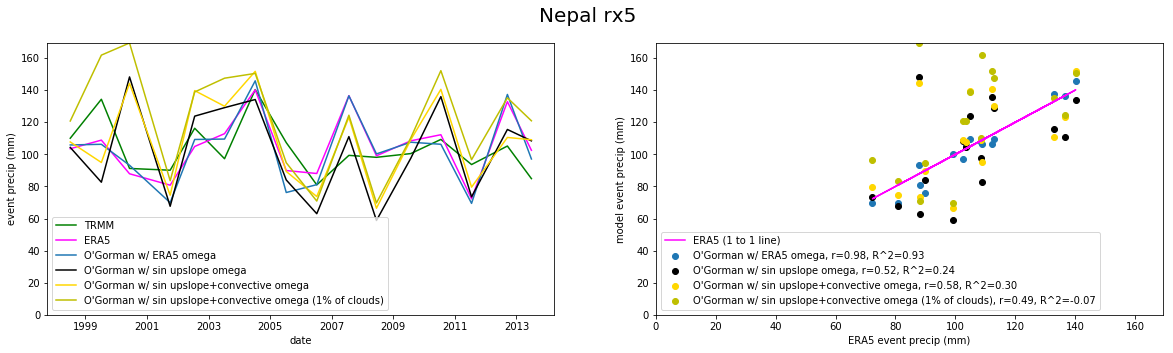

In [17]:
ct = "nepal"
pr=prnep
ax1,ax2 = plot_precips(rx5_datetime[ct],pr,names[ct])

None

In [18]:
ct = "Sandes"
prSan= retrieve_modeled_precip("rx5",rx5[ct],box[ct]["small"],ct,["omegaERA5Xqinteg.plev8_4","omegaupslopemean200Xqinteg.plev8_4","omegaupslopesinXqinteg.plev8_4","omegaupslopeblqesinXqinteg.plev8_1","omegaupslopeblqeWRONGsinXqinteg.plev8_4"],1,0,1)


In [23]:
ct = "Sandes"
pr=prSan
prdict = {"ERA5":(pr[-1],"magenta"),
          "TRMM":(pr[-2],"green"),
          "O'Gorman + ERA5 omega ":(pr[0],"dodgerblue"),
          "O'Gorman + upslope omega,mean ":(pr[1],"orange"),
          "O'Gorman + upslope omega ":(pr[2],"black"),
          "O'Gorman + upslope/BLQE omega ":(pr[3],"gold"),
         }
fig_ts,fig_sc=plot_precips_bokeh(rx5_datetime[ct],prdict,names[ct])
show(row(fig_ts,fig_sc))

In [24]:
ct = "Candes"
prCan= retrieve_modeled_precip("rx5",rx5[ct],box[ct]["small"],ct,["omegaERA5Xqinteg.plev8_4","omegaupslopemean200Xqinteg.plev8_4","omegaupslopesinXqinteg.plev8_4","omegaupslopeblqesinXqinteg.plev8_1","omegaupslopeblqe2sinXqinteg.plev8_1"],1,0,1)


In [25]:
ct = "Candes"
pr=prCan
prdict = {"ERA5":(pr[-1],"magenta"),
          "TRMM":(pr[-2],"green"),
          "O'Gorman + ERA5 omega ":(pr[0],"dodgerblue"),
          "O'Gorman + upslope omega,mean ":(pr[1],"orange"),
          "O'Gorman + upslope omega ":(pr[2],"black"),
          "O'Gorman + upslope/BLQE omega ":(pr[3],"gold"),
         }
fig_ts,fig_sc=plot_precips_bokeh(rx5_datetime[ct],prdict,names[ct])
show(row(fig_ts,fig_sc))

In [26]:
ct = "california"
prcal= retrieve_modeled_precip("rx5",rx5[ct],box[ct]["small"],ct,["omegaERA5Xqinteg.plev8_4","omegaupslopemean200Xqinteg.plev8_4","omegaupslopesinXqinteg.plev8_4","omegaupslopeblqesinXqinteg.plev8_1"],1,0,1)


In [27]:
ct = "california"
pr=prcal
prdict = {"ERA5":(pr[-1],"magenta"),
          "TRMM":(pr[-2],"green"),
          "O'Gorman + ERA5 omega ":(pr[0],"dodgerblue"),
          "O'Gorman + upslope omega,mean ":(pr[1],"orange"),
          "O'Gorman + upslope omega ":(pr[2],"black"),
          "O'Gorman + upslope/BLQE omega ":(pr[3],"gold"),
         }
fig_ts,fig_sc=plot_precips_bokeh(rx5_datetime[ct],prdict,names[ct])
show(row(fig_ts,fig_sc))

In [28]:
ct = "cascades"
prcas= retrieve_modeled_precip("rx5",rx5[ct],box[ct]["small"],ct,["omegaERA5Xqinteg.plev8_4","omegaupslopemean200Xqinteg.plev8_4","omegaupslopesinXqinteg.plev8_4","omegaupslopeblqesinXqinteg.plev8_1"],1,0,1)


In [29]:
ct = "cascades"
pr=prcas
prdict = {"ERA5":(pr[-1],"magenta"),
          "TRMM":(pr[-2],"green"),
          "O'Gorman + ERA5 omega ":(pr[0],"dodgerblue"),
          "O'Gorman + upslope omega,mean ":(pr[1],"orange"),
          "O'Gorman + upslope omega ":(pr[2],"black"),
          "O'Gorman + upslope/BLQE omega ":(pr[3],"gold"),
         }
fig_ts,fig_sc=plot_precips_bokeh(rx5_datetime[ct],prdict,names[ct])
show(row(fig_ts,fig_sc))

## omega at 700 vs vertical integral

$\omega_{700}q_s(surface)$  &nbsp;   vs  &nbsp;  $-\left\{\omega\left.\dfrac{dq_s}{dp}\right|_{\theta_e}\right\}$

Text(0.5, 1.0, 'nepal rx5')

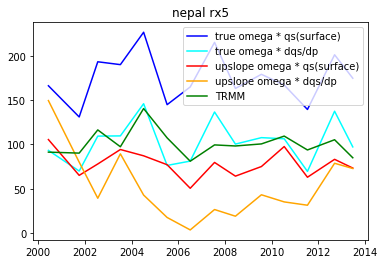

In [61]:
days=[pd.to_datetime(d, format='%Y%m%d') for d in rx5nepal[2:]]
plt.plot(days,np.array(prnep_era5_qs)   ,label="true omega * qs(surface)",color="b")
plt.plot(days,np.array(prnep_era5_og[2:])   ,label="true omega * dqs/dp",color="cyan")

plt.plot(days,np.array(prnep_ups_qs)   ,label="upslope omega * qs(surface)",color="red")
plt.plot(days,np.array(prnep_ups_og)   ,label="upslope omega * dqs/dp",color="orange")

plt.plot(days,np.array(prnep_trmm[2:]),label="TRMM",color="green")
plt.legend()
plt.title("nepal rx5")  

Text(0.5, 1.0, 'chile rx5')

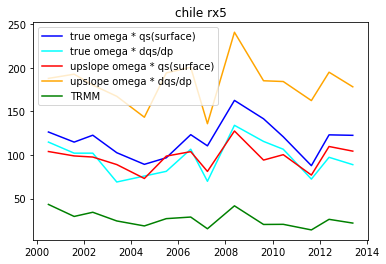

In [62]:
days=[pd.to_datetime(d, format='%Y%m%d') for d in rx5chile]
plt.plot(days,np.array(prchi_era5_qs)   ,label="true omega * qs(surface)",color="b")
plt.plot(days,np.array(prchi_era5_og)   ,label="true omega * dqs/dp",color="cyan")

plt.plot(days,np.array(prchi_ups_qs)   ,label="upslope omega * qs(surface)",color="red")
plt.plot(days,np.array(prchi_ups_og)   ,label="upslope omega * dqs/dp",color="orange")

plt.plot(days,np.array(prchi_trmm),label="TRMM",color="green")
plt.legend()
plt.title("chile rx5")  

## Precip maps and correlation maps for the models and TRMM - Nepal and Chile

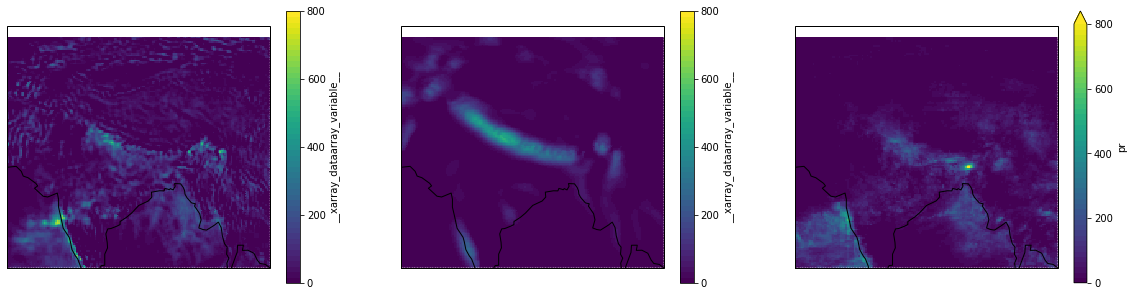

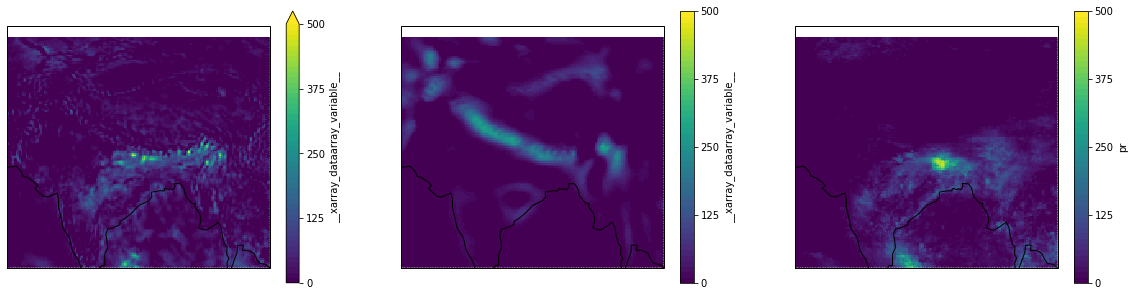

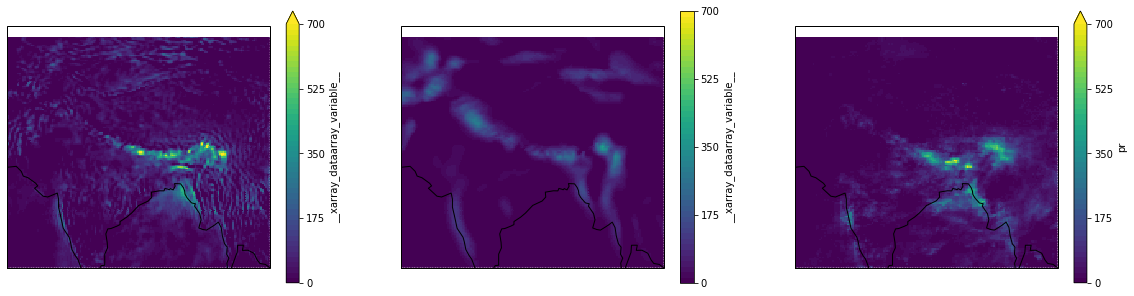

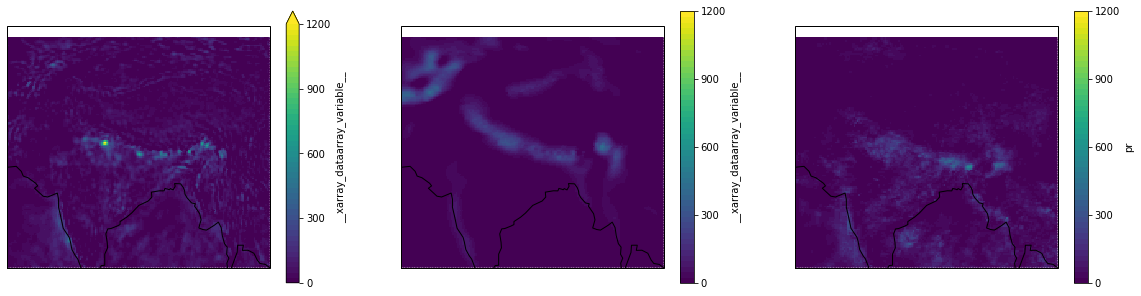

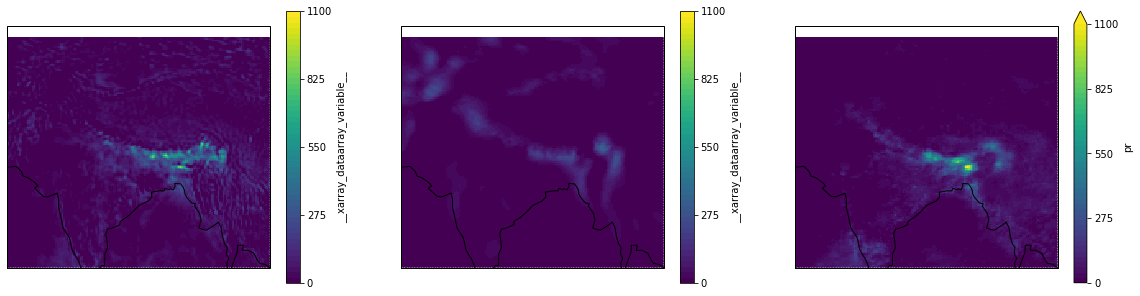

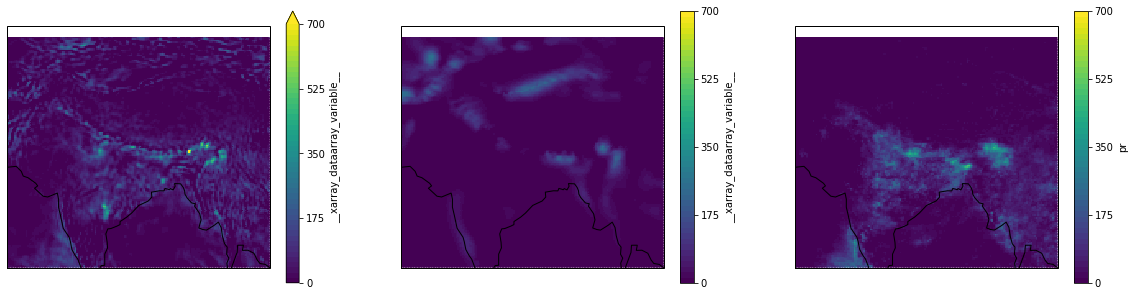

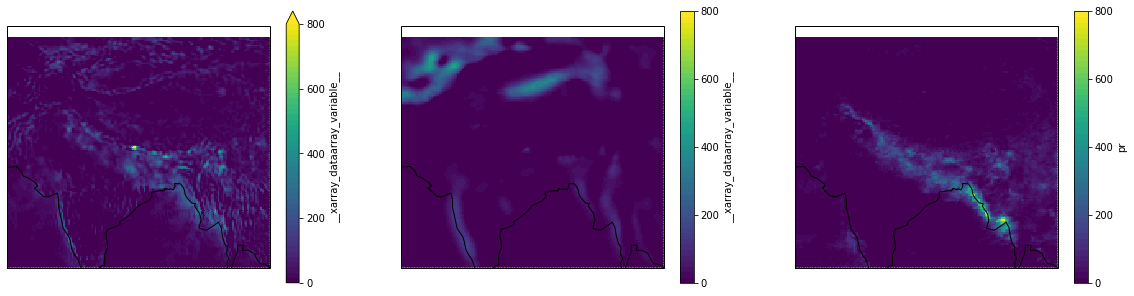

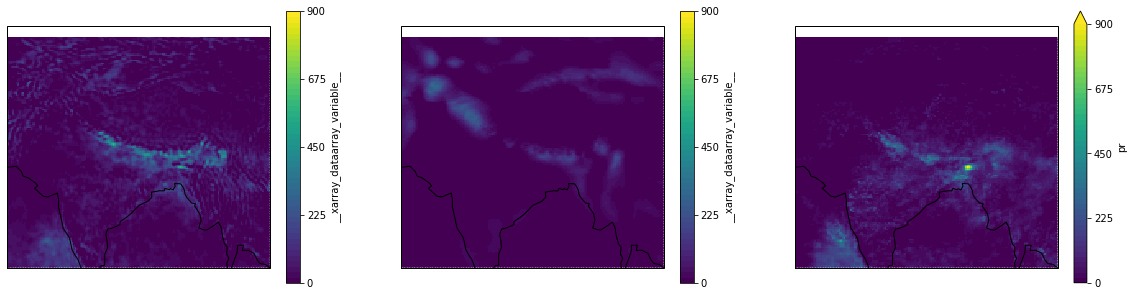

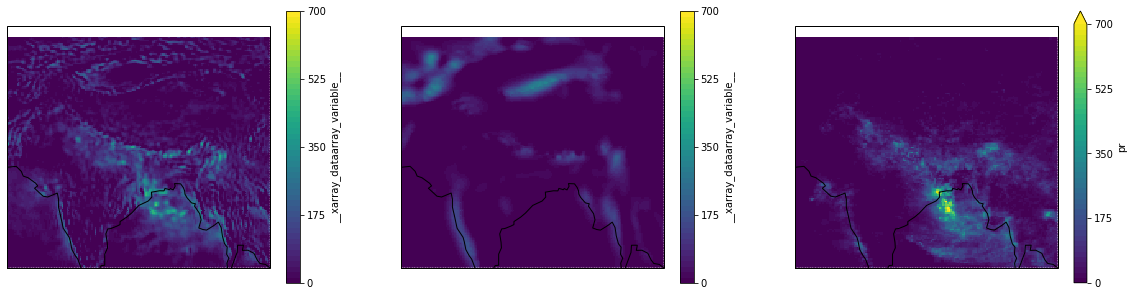

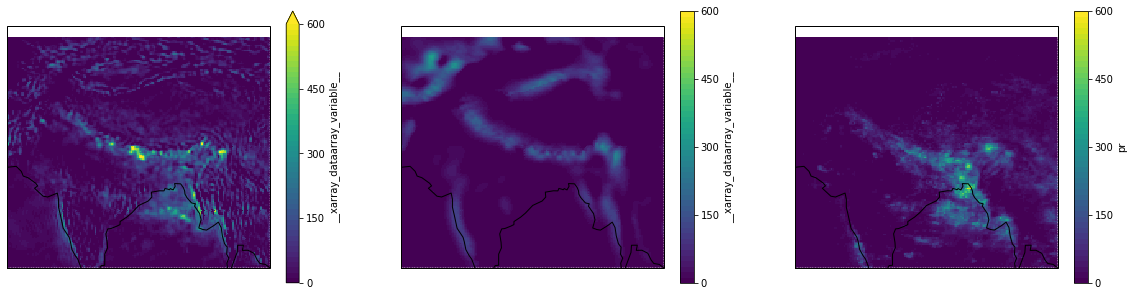

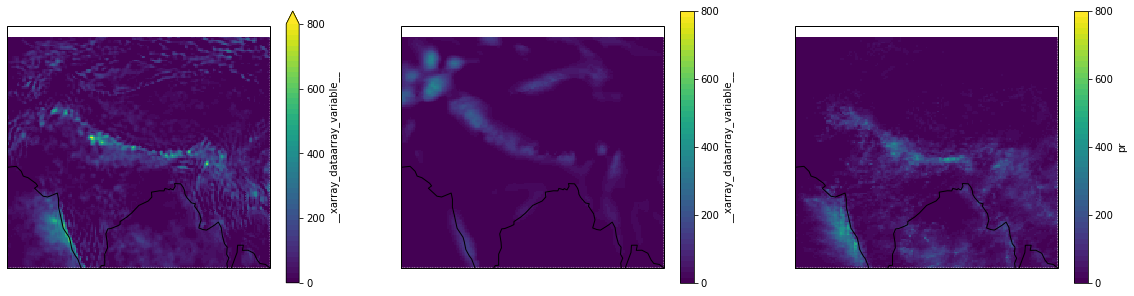

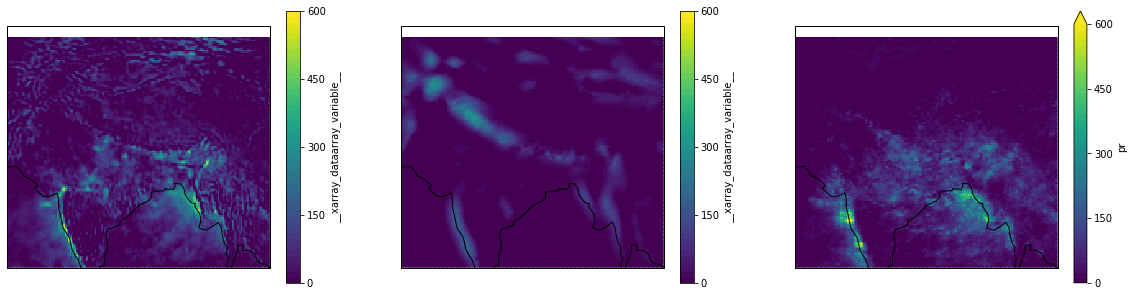

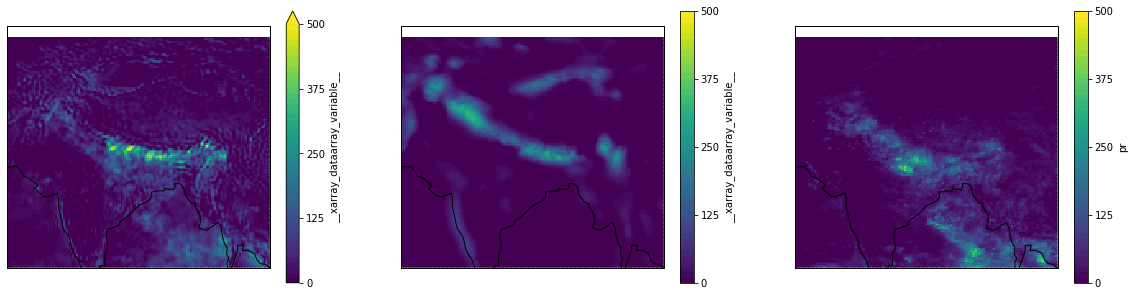

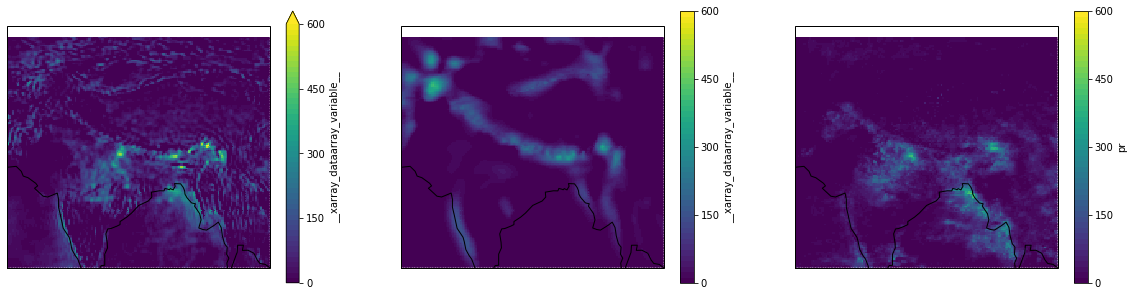

In [137]:
ct="nepal2"
ds=rx5nepal
country=nepal
for d in ds :
    pr1 = xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/rx5/pr/pr.omegaERA5Xqinteg.%s.%s.nc"%(d,ct)).__xarray_dataarray_variable__
    pr2 = xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/rx5/pr/pr.omegaupslopeXqinteg.%s.%s.nc"%(d,ct)).__xarray_dataarray_variable__
    prtrmm = precipTRMM5d(d,country)
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5),subplot_kw={'projection': ccrs.PlateCarree()})

    M=100*(int(max([pr1.max(),pr2.max(),prtrmm.max()]))//100)
    
    ax1.coastlines()
    pr1.plot(ax=ax1,transform=ccrs.PlateCarree(),levels=np.linspace(0,M), cbar_kwargs={"ticks": np.linspace(0,M,5)})
    ax1.set_extent(country)

    ax2.coastlines()
    pr2.plot(ax=ax2,transform=ccrs.PlateCarree(),levels=np.linspace(0,M), cbar_kwargs={"ticks": np.linspace(0,M,5)})
    ax2.set_extent(country)
    
    ax3.coastlines()
    prtrmm.plot(ax=ax3,transform=ccrs.PlateCarree(),levels=np.linspace(0,M), cbar_kwargs={"ticks": np.linspace(0,M,5)})
    ax3.set_extent(country)


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0.5, 1.0, 'corr coef, true omega model vs trmm')

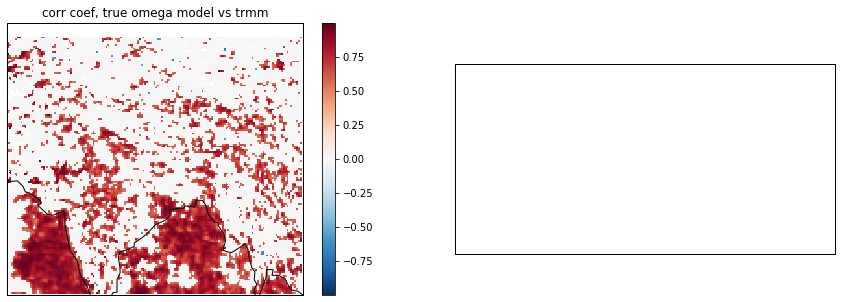

In [144]:
ct="nepal2"
ds=rx5nepal
country=nepal
allpr1l,prtrmml=[],[]
for d in ds :
    pr1 = xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/rx5/pr/pr.omegaERA5Xqinteg.%s.%s.nc"%(d,ct)).__xarray_dataarray_variable__
    pr2 = xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/rx5/pr/pr.omegaupslopeXqinteg.%s.%s.nc"%(d,ct)).__xarray_dataarray_variable__
    prt = precipTRMM5d(d,country)
    allpr1l.append(pr1)
    prtrmml.append(prt)
allpr1=xr.concat(allpr1l,"time")
prtrmm=xr.concat(prtrmml,"time")
prtrmm=prtrmm.rename({'lat': 'latitude','lon': 'longitude'}).interp_like(allpr1).fillna(0.)

c=xr.apply_ufunc(corrc,allpr1,prtrmm,input_core_dims=[['time'], ['time']],vectorize=True)
p=xr.apply_ufunc(corrp,allpr1,prtrmm,input_core_dims=[['time'], ['time']],vectorize=True)
cp = c*(1*(p<0.05))
#t=time.time()
#allpr1m = allpr1.mean("time")
#prtrmmm = prtrmm.mean("time")
#
#print(allpr1)
#print(prtrmm)
#
#prod = (allpr1 - allpr1m)*(prtrmm-prtrmmm)
#vallpr1 = (allpr1 - allpr1m)**2
#vprtrmm = (prtrmm-prtrmmm)**2
#print(time.time()-t)
#cp= prod.sum("time")/np.sqrt(vallpr1.sum("time")*vprtrmm.sum("time"))

#l=xr.apply_ufunc(lr,allpr1,prtrmm,input_core_dims=[['time'], ['time']],vectorize=True)
#p=xr.apply_ufunc(lrp,allpr1,prtrmm,input_core_dims=[['time'], ['time']],vectorize=True)
#lp = l*(1*(p<0.05))

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),subplot_kw={'projection': ccrs.PlateCarree()})

ax1.coastlines()
cp.plot(ax=ax1,transform=ccrs.PlateCarree())
ax1.set_extent(nepal)
ax1.set_title("corr coef, true omega model vs trmm")

#ax2.coastlines()
#lp.plot(ax=ax2,transform=ccrs.PlateCarree())
#ax2.set_extent(nepal)
#ax2.set_title("linear regression slope")

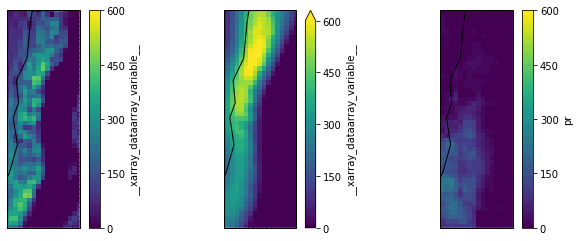

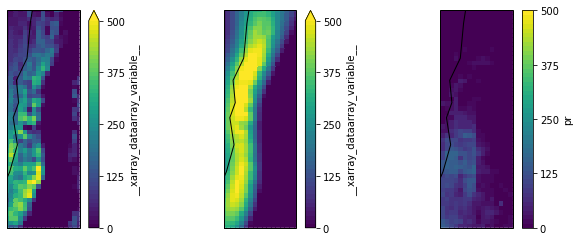

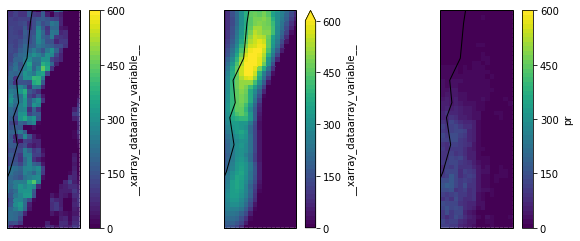

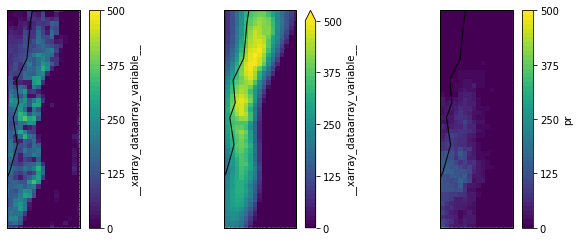

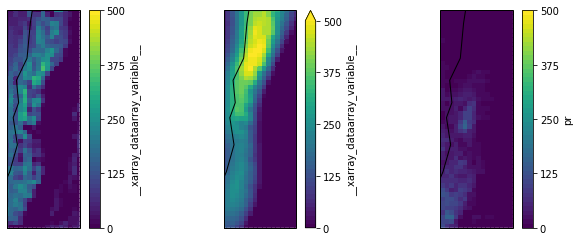

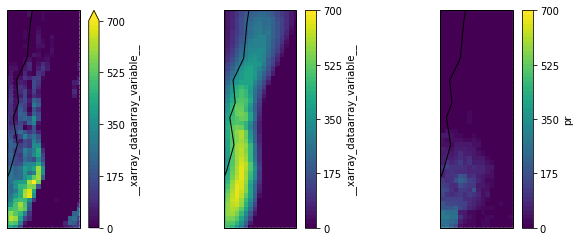

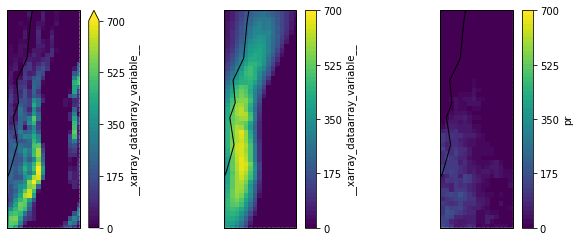

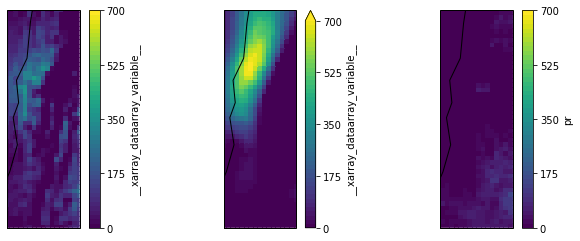

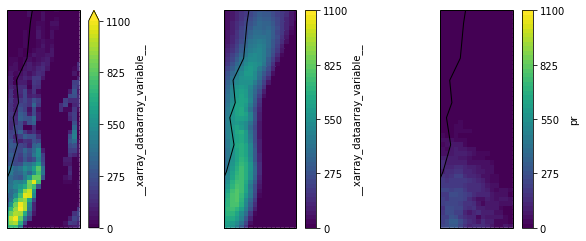

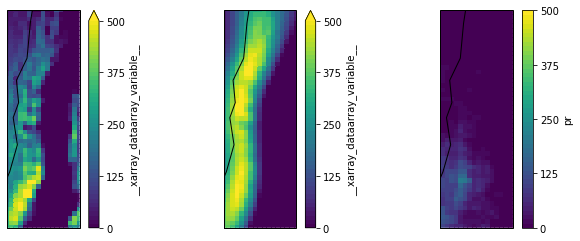

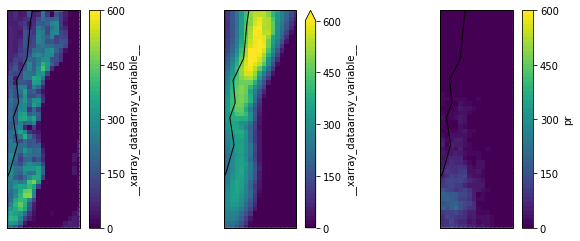

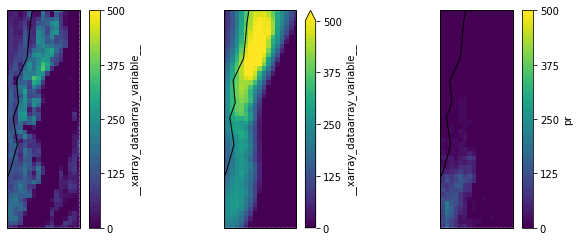

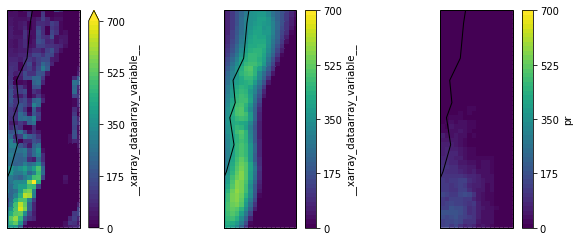

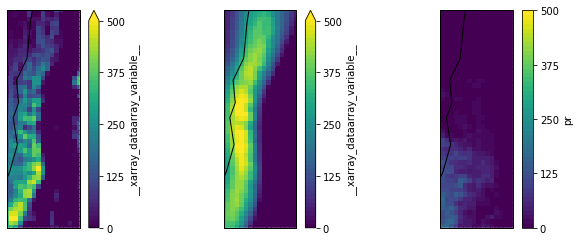

In [148]:
ct="chile"
ds=rx5chile
country=chile1
for d in ds :
    pr1 = xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/rx5/pr/pr.omegaERA5Xqinteg.%s.%s.nc"%(d,ct)).__xarray_dataarray_variable__
    pr2 = xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/rx5/pr/pr.omegaupslopeXqinteg.%s.%s.nc"%(d,ct)).__xarray_dataarray_variable__
    prtrmm = precipTRMM5d(d,country)
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(11,4),subplot_kw={'projection': ccrs.PlateCarree()})

    M=100*(int(max([pr1.max(),pr2.max(),prtrmm.max()]))//100)
    
    ax1.coastlines()
    pr1.plot(ax=ax1,transform=ccrs.PlateCarree(),levels=np.linspace(0,M), cbar_kwargs={"ticks": np.linspace(0,M,5)})
    ax1.set_extent(country)

    ax2.coastlines()
    pr2.plot(ax=ax2,transform=ccrs.PlateCarree(),levels=np.linspace(0,M), cbar_kwargs={"ticks": np.linspace(0,M,5)})
    ax2.set_extent(country)
    
    ax3.coastlines()
    prtrmm.plot(ax=ax3,transform=ccrs.PlateCarree(),levels=np.linspace(0,M), cbar_kwargs={"ticks": np.linspace(0,M,5)})
    ax3.set_extent(country)


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0.5, 1.0, 'corr coef, upslope omega model vs trmm')

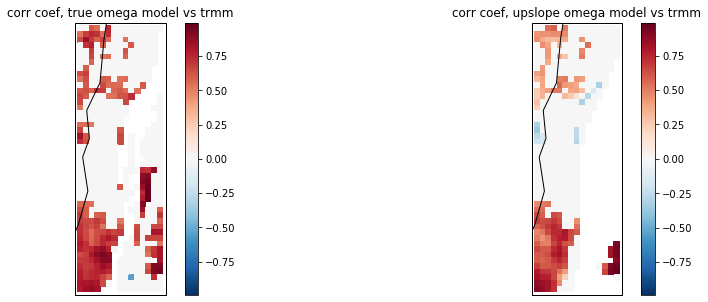

In [152]:
ct="chile"
ds=rx5chile
country=chile1
allpr1l,allpr2l,prtrmml=[],[],[]
for d in ds :
    pr1 = xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/rx5/pr/pr.omegaERA5Xqinteg.%s.%s.nc"%(d,ct)).__xarray_dataarray_variable__
    pr2 = xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/rx5/pr/pr.omegaupslopeXqinteg.%s.%s.nc"%(d,ct)).__xarray_dataarray_variable__
    prt = precipTRMM5d(d,country)
    allpr1l.append(pr1)
    allpr2l.append(pr2)
    prtrmml.append(prt)
allpr1=xr.concat(allpr1l,"time")
allpr2=xr.concat(allpr2l,"time")
prtrmm=xr.concat(prtrmml,"time")
prtrmm=prtrmm.rename({'lat': 'latitude','lon': 'longitude'}).interp_like(allpr1).fillna(0.)

c=xr.apply_ufunc(corrc,allpr1,prtrmm,input_core_dims=[['time'], ['time']],vectorize=True)
p=xr.apply_ufunc(corrp,allpr1,prtrmm,input_core_dims=[['time'], ['time']],vectorize=True)
cp = c*(1*(p<0.05))

c2=xr.apply_ufunc(corrc,allpr2,prtrmm,input_core_dims=[['time'], ['time']],vectorize=True)
p2=xr.apply_ufunc(corrp,allpr2,prtrmm,input_core_dims=[['time'], ['time']],vectorize=True)
cp2 = c2*(1*(p<0.05))

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),subplot_kw={'projection': ccrs.PlateCarree()})

ax1.coastlines()
cp.plot(ax=ax1,transform=ccrs.PlateCarree())
ax1.set_extent(country)
ax1.set_title("corr coef, true omega model vs trmm")

ax2.coastlines()
cp2.plot(ax=ax2,transform=ccrs.PlateCarree())
ax2.set_extent(country)
ax2.set_title("corr coef, upslope omega model vs trmm")

## TRMM vs GPCP vs ERA5

In [16]:
dictprecip = {k:retrieve_modeled_precip("rx5",rx5[k],box[k]["small"],None,[],1,1,1) for k in ["nepal","chile","Sandes","Candes","california"]}


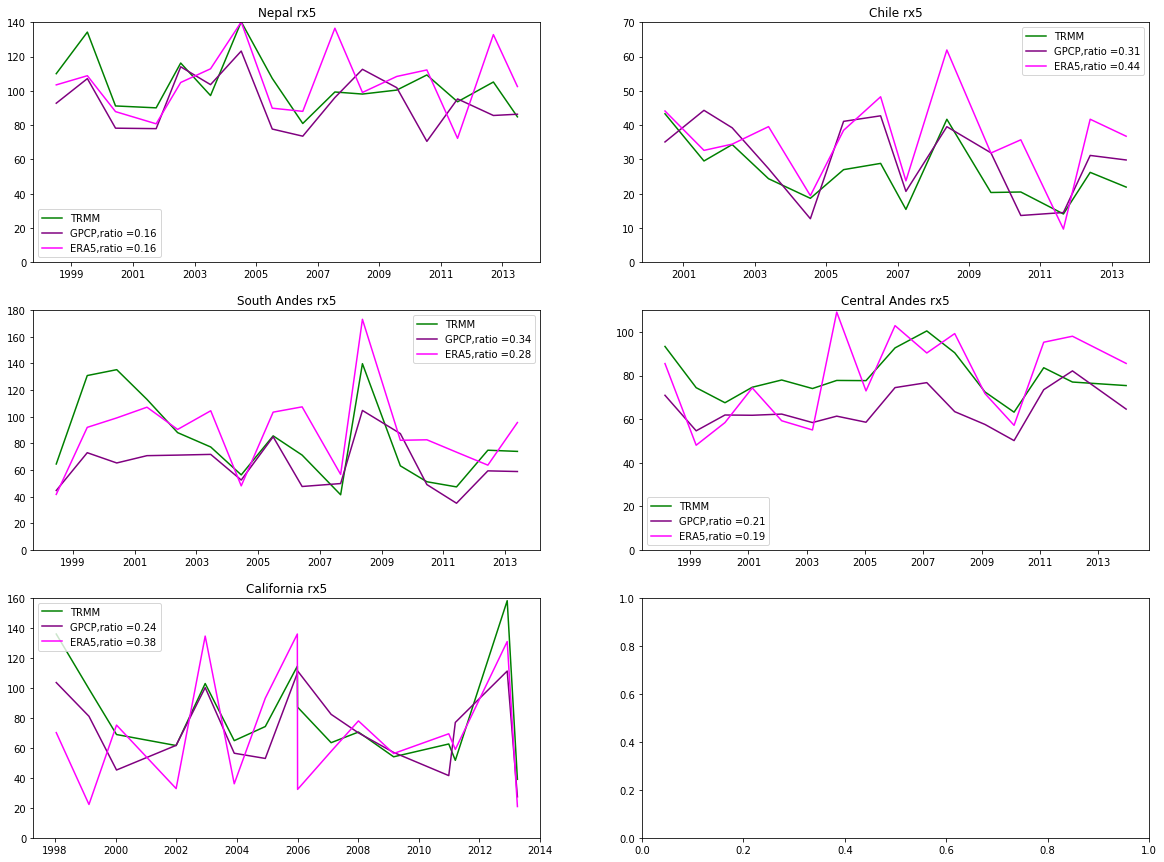

In [19]:
lims=[140,70,180,110,160]

_,ax=plt.subplots(3,2,figsize=(20,15))
axs= ax.reshape(-1)

for i,k in enumerate(dictprecip.keys()):
    ratio_gpcp = np.linalg.norm(dictprecip[k][1]-dictprecip[k][0])/np.linalg.norm(dictprecip[k][0])
    ratio_era5 = np.linalg.norm(dictprecip[k][2]-dictprecip[k][0])/np.linalg.norm(dictprecip[k][0])
    axs[i].plot(rx5_datetime[k],dictprecip[k][0],label="TRMM",color="green")
    axs[i].plot(rx5_datetime[k],dictprecip[k][1],label="GPCP,ratio =%.2f"%ratio_gpcp,color="purple")
    axs[i].plot(rx5_datetime[k],dictprecip[k][2],label="ERA5,ratio =%.2f"%ratio_era5,color="magenta")
    axs[i].legend()
    axs[i].set_ylim(0,lims[i])
    axs[i].set_title(names[k]+" rx5")   

